<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20TMS%20feature%20Shapley%20vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Install necessary packages (if not already installed in the environment) ---
# We'll use H2O for AutoML
!pip install h2o --quiet

# --- Import necessary libraries ---
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import warnings
warnings.filterwarnings("ignore") # Suppress potential warnings

# --- 1. Initialize H2O ---
print("Initializing H2O...")
h2o.init()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 4.9 MB/s eta 0:00:00
Initializing H2O...
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpsatwmcor
  JVM stdout: /tmp/tmpsatwmcor/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpsatwmcor/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_1i9apo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.147 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [2]:
link_url = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/tms_timeseries_clusters.csv'

raw_data = pd.read_csv(link_url, sep = ',')
raw_data = raw_data.drop('Unnamed: 0',axis=1)
raw_data.head(5)

,patient_id,Avg_Resp_Left_Mean,Avg_Resp_Left_Std,Avg_Resp_Left_Hurst,Avg_Resp_Right_Mean,Avg_Resp_Right_Std,Avg_Resp_Right_Hurst,Avg_Resp_DTW_Cluster,Inh_Thresh_DTW_Cluster
0,patient_ 1,178.163333,67.882676,1.257902,140.767500,27.082901,0.291345,1,1
1,patient_ 2,51.333667,30.594125,1.937557,73.485333,30.241820,0.849184,2,2
2,patient_ 3,189.062500,63.825718,1.729370,145.275000,35.421334,0.495146,1,2
3,patient_ 4,88.539167,29.056679,0.237006,66.661917,16.158868,0.504025,2,2
4,patient_ 5,59.761333,46.520112,1.369517,59.291833,28.441472,1.495100,2,2


In [3]:
df = raw_data

In [4]:
# --- 3. Data Preprocessing for H2O ---
# Identify columns to use for modeling (features and potential targets)
# Exclude 'patient_id' as it's an identifier
all_columns = df.columns.tolist()
feature_columns = [col for col in all_columns if col != 'patient_id']

print(f"\nAll columns: {all_columns}")
print(f"\nFeature columns identified: {feature_columns}")

# Handle missing values (H2O can handle some NA, but for consistency in target evaluation,
# let's drop rows with any missing values in potential target columns)
# It's often better to let H2O handle missing values internally for features during modeling.
# However, for evaluating target performance, clean targets are needed.
# Let's drop rows where ANY column has missing values for this analysis.
df_clean = df.dropna()
print(f"\nShape after dropping rows with missing values: {df_clean.shape}")

X_clean_df = df_clean[feature_columns].copy()
y_potential_df = df_clean[feature_columns] # All features are potential targets

# Convert the clean pandas DataFrame to an H2O Frame
h2o_df = h2o.H2OFrame(df_clean)
print("\nData successfully converted to H2O Frame.")


All columns: ['patient_id', 'Avg_Resp_Left_Mean', 'Avg_Resp_Left_Std', 'Avg_Resp_Left_Hurst', 'Avg_Resp_Right_Mean', 'Avg_Resp_Right_Std', 'Avg_Resp_Right_Hurst', 'Avg_Resp_DTW_Cluster', 'Inh_Thresh_DTW_Cluster']

Feature columns identified: ['Avg_Resp_Left_Mean', 'Avg_Resp_Left_Std', 'Avg_Resp_Left_Hurst', 'Avg_Resp_Right_Mean', 'Avg_Resp_Right_Std', 'Avg_Resp_Right_Hurst', 'Avg_Resp_DTW_Cluster', 'Inh_Thresh_DTW_Cluster']

Shape after dropping rows with missing values: (44, 9)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

Data successfully converted to H2O Frame.


In [5]:
# --- 4. Define a function to evaluate H2O AutoML performance for each potential target column ---
def find_best_target_h2o_automl(h2o_frame, feature_cols, potential_target_cols, max_runtime_secs=120):
    """
    Iterates through each column in potential_target_cols, treating it as a target,
    and uses H2O AutoML to build a model. The performance (e.g., R2 for regression,
    AUC/M logloss for classification) of the model is used as a proxy to determine
    the 'best' target column. Higher performance might indicate that the column
    is easier to predict from the other features, suggesting a strong underlying
    relationship or structure.
    """
    results = {}
    best_score = float('-inf') # We'll use a generic 'score', taking the primary metric
    best_column = None
    best_task = None
    best_leaderboard = None

    for col in potential_target_cols:
        print(f"\n--- Evaluating '{col}' as potential target ---")
        y = col
        X = [c for c in feature_cols if c != y] # Use all other features as predictors

        # Determine task type based on the target column's data type in the H2O frame
        h2o_type = h2o_frame.type(col)
        print(f"  H2O determined type for '{col}': {h2o_type}")

        # H2O usually infers 'enum' for categorical/string and 'int'/'real' for numeric.
        # For integer columns that might represent clusters (classification),
        # H2O might still treat them as regression. We might need to explicitly convert.
        # Let's assume H2O's inference is mostly correct for now, but check unique values.
        unique_vals_frame = h2o_frame[y].unique()
        unique_count = unique_vals_frame.nrows
        total_count = h2o_frame.nrows
        print(f"  Unique values in '{col}': {unique_count}")

        if h2o_type == 'enum' or unique_count < max(2, total_count * 0.05): # Treat as classification
             task = 'classification'
             # Ensure the target is treated as enum if it's numeric but categorical
             h2o_frame[y] = h2o_frame[y].asfactor()
        elif h2o_type in ['int', 'real']:
             task = 'regression'
        else:
            print(f"  Skipping '{col}' due to unsupported H2O type: {h2o_type}")
            continue

        print(f"  Determined task type: {task}")

        # Split the H2O frame
        train, test = h2o_frame.split_frame(ratios=[0.8], seed=42)

        # Initialize H2O AutoML
        aml = H2OAutoML(
            max_runtime_secs=max_runtime_secs, # Run for max 2 minutes per target
            seed=42,
            verbosity='info' # Can be 'info', 'warn', 'quiet' to manage output
        )

        # Fit the AutoML model
        print(f"  Fitting H2O AutoML for {task} on '{col}'...")
        aml.train(x=X, y=y, training_frame=train)

        # Check the leaderboard for the best model's performance
        lb = aml.leaderboard
        print(lb.head())

        if lb.nrows == 0:
            print(f"  No models were trained successfully for target '{col}'. Skipping.")
            continue

        # Get the primary metric for the best model
        # H2O AutoML leaderboard has standard column names.
        # For regression: 'r2', 'rmse', 'mae', 'deviance'
        # For classification: 'mean_per_class_error', 'logloss', 'AUC' (if binary), 'AUCpr'
        # We'll take the best model's R2 for regression or mean_per_class_error (minimize) or logloss (minimize) for classification.
        best_model_id = lb[0, 'model_id']
        print(f"  Best model for '{col}': {best_model_id}")

        if task == 'regression':
            # Look for R2 score (higher is better)
            if 'r2' in lb.columns:
                score_val = lb[0, 'r2']
                score_name = "R2"
                if score_val is not None:
                    score_val = float(score_val) # H2O returns H2OFloat, convert to Python float
                    score = score_val # Higher R2 is better
                else:
                     print(f"    R2 not found for best model of '{col}', using 0.")
                     score = 0.0
            else:
                # If R2 is not present (e.g., if all models failed to report it), use another metric like negative RMSE
                rmse_val = lb[0, 'rmse']
                if rmse_val is not None:
                    rmse_val = float(rmse_val)
                    score = -rmse_val # Negative RMSE, so higher (less negative) is better
                    score_name = "-RMSE"
                else:
                     print(f"    R2 and RMSE not found for best model of '{col}', using 0.")
                     score = 0.0
                     score_name = "Placeholder"

        elif task == 'classification':
             # Look for mean_per_class_error (lower is better) or logloss (lower is better)
             # We want a score where HIGHER is better, so we'll use negative error or inverse of logloss if needed.
             # logloss is usually lower for better models. We can use negative logloss.
             if 'logloss' in lb.columns and lb[0, 'logloss'] is not None:
                 logloss_val = float(lb[0, 'logloss'])
                 score = -logloss_val # Negative logloss, so higher (less negative) is better
                 score_name = "-LogLoss"
             elif 'mean_per_class_error' in lb.columns and lb[0, 'mean_per_class_error'] is not None:
                  mce_val = float(lb[0, 'mean_per_class_error'])
                  score = -mce_val # Negative mean per class error, so higher (less negative) is better
                  score_name = "-MeanPerClassError"
             elif 'auc' in lb.columns and lb[0, 'auc'] is not None: # For binary classification
                  auc_val = float(lb[0, 'auc'])
                  score = auc_val # AUC, higher is better
                  score_name = "AUC"
             else:
                 print(f"    No standard classification metric found for best model of '{col}', using 0.")
                 score = 0.0
                 score_name = "Placeholder"

        print(f"  Best {score_name} for '{col}': {score:.4f}")

        results[col] = {
            'score': score,
            'score_name': score_name,
            'task': task,
            'leaderboard': lb
        }

        # Update best column if current score is better
        # Note: This comparison works if score is consistently higher for better performance
        if score > best_score:
            best_score = score
            best_column = col
            best_task = task
            best_leaderboard = lb

    print("\n--- Summary of H2O AutoML Performance for Potential Targets ---")
    # Sort results by score (descending) for better readability
    sorted_results = sorted(results.items(), key=lambda item: item[1]['score'], reverse=True)
    for col, res in sorted_results:
        print(f"  {col:<25} | {res['score_name']:<15} | {res['score']:.4f} | Task: {res['task']}")
    print(f"\nBest target column based on H2O AutoML performance: '{best_column}' with {results[best_column]['score_name']}: {best_score:.4f} (Task: {best_task})")

    return best_column, best_score, best_task, results, best_leaderboard


# --- Run the H2O AutoML-based target identification ---
best_target_col, best_score, best_task, all_results, best_lb = find_best_target_h2o_automl(
    h2o_df, feature_columns, y_potential_df.columns, max_runtime_secs=120
)

# --- Print the leaderboard for the best target ---
print(f"\n--- Leaderboard for the Best Target ('{best_target_col}') ---")
print(best_lb)

# --- 5. Shutdown H2O ---
print("\nShutting down H2O...")
h2o.shutdown(prompt=False)

print("\nDone.")


--- Evaluating 'Avg_Resp_Left_Mean' as potential target ---
  H2O determined type for 'Avg_Resp_Left_Mean': real
  Unique values in 'Avg_Resp_Left_Mean': 43
  Determined task type: regression
  Fitting H2O AutoML for regression on 'Avg_Resp_Left_Mean'...
AutoML progress: |
18:35:48.672: Project: AutoML_1_20251207_183548
18:35:48.676: 5-fold cross-validation will be used.
18:35:48.677: Setting stopping tolerance adaptively based on the training frame: 0.05
18:35:48.677: Build control seed: 42
18:35:48.678: training frame: Frame key: AutoML_1_20251207_183548_training_py_3_sid_986c    cols: 9    rows: 38  chunks: 1    size: 3116  checksum: -793253920710519072
18:35:48.678: validation frame: NULL
18:35:48.679: leaderboard frame: NULL
18:35:48.679: blending frame: NULL
18:35:48.679: response column: Avg_Resp_Left_Mean
18:35:48.679: fold column: null
18:35:48.680: weights column: null
18:35:48.709: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid

# Shapley values
Initialize H2O, load `df_clean` into an H2OFrame, retrieve the best model using `best_lb`, calculate Shapley values for the best model on the training data, and then visualize the feature importance using these Shapley values.

In [6]:
!pip install shap --quiet

**Reasoning**:
Re-initialize H2O and import the shap library as requested by the subtask.



In [7]:
#import h2o
import shap

print("Re-initializing H2O...")
h2o.init()

Re-initializing H2O...
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwe_pufhx
  JVM stdout: /tmp/tmpwe_pufhx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwe_pufhx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_5bd0ji
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [8]:
# Re-create H2OFrame for the current session
h2o_df_current_session = h2o.H2OFrame(df_clean)

# Get the best target column and task from the previous analysis
y_col = best_target_col
x_cols = [col for col in feature_columns if col != y_col]
task = best_task

# Ensure the target column is correctly typed for the task in the current H2OFrame
if task == 'classification':
    h2o_df_current_session[y_col] = h2o_df_current_session[y_col].asfactor()

print(f"Re-running AutoML for target '{y_col}' (Task: {task}) to obtain a valid model in the current H2O session...")

# Re-run AutoML for the best target column in the current session
aml_current_session = H2OAutoML(
    max_runtime_secs=60, # Reduced runtime to quickly get a model for SHAP
    seed=42,
    verbosity='warn'
)
aml_current_session.train(x=x_cols, y=y_col, training_frame=h2o_df_current_session)

# Get the new best model from the current session's AutoML leaderboard
current_best_lb = aml_current_session.leaderboard
model_id = current_best_lb[0, 'model_id']
best_model = h2o.get_model(model_id)

# Convert feature data to H2OFrame for SHAP, excluding the target column
h2o_feature_frame = h2o.H2OFrame(df_clean[[col for col in feature_columns if col != y_col]])

print(f"Loaded best model from current session: {best_model.model_id}")
print("Feature data converted to H2OFrame.")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Re-running AutoML for target 'Avg_Resp_DTW_Cluster' (Task: regression) to obtain a valid model in the current H2O session...
AutoML progress: |████
18:52:36.677: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 44.0.

███████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Loaded best model from current session: GBM_grid_1_AutoML_1_20251207_185230_model_8
Feature data converted to H2OFrame.


**Reasoning**:
Now that the H2O model and feature data are ready, I will calculate SHAP values using `shap.TreeExplainer` for the first two data points from the `h2o_feature_frame`. This will provide the necessary values to create individual force plots as requested by the subtask.



In [9]:
contributions = best_model.predict_contributions(h2o_feature_frame)

# Convert the H2OFrame contributions to a pandas DataFrame
contributions_df = contributions.as_data_frame()

# Extract SHAP values (all columns except 'BiasTerm')
shap_values_individual = contributions_df.drop(columns=['BiasTerm']).values

# The 'BiasTerm' represents the expected value (base value)
# We take the first value as expected_value is typically constant for a given model or dataset
expected_value = contributions_df['BiasTerm'].iloc[0]

print(f"SHAP values calculated using H2O's predict_contributions.")
print(f"Calculated SHAP values for {len(shap_values_individual)} instances.")
print(f"Expected (base) value: {expected_value}")

contributions progress: |████████████████████████████████████████████████████████| (done) 100%
SHAP values calculated using H2O's predict_contributions.
Calculated SHAP values for 44 instances.
Expected (base) value: 1.409090876579285


Generating SHAP force plot for instance 1...


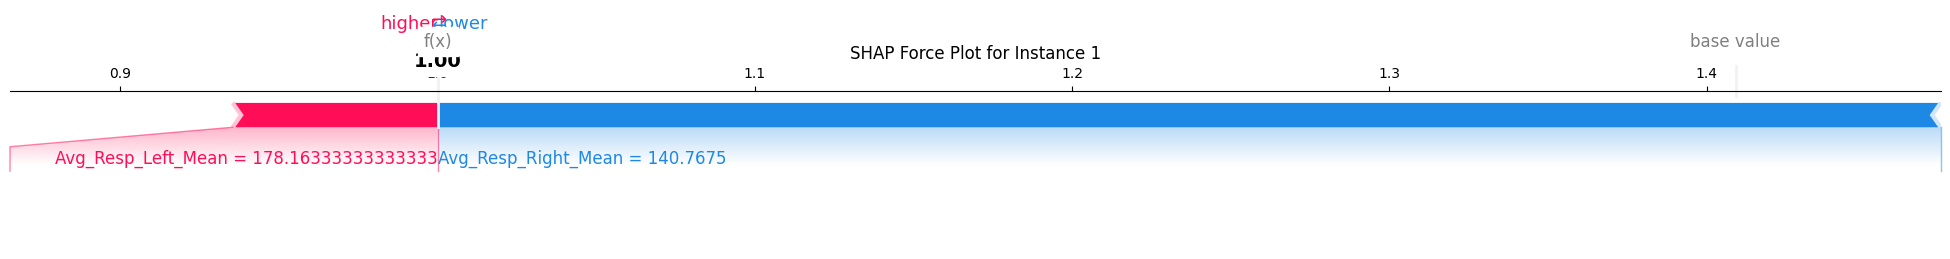

Generating SHAP force plot for instance 2...


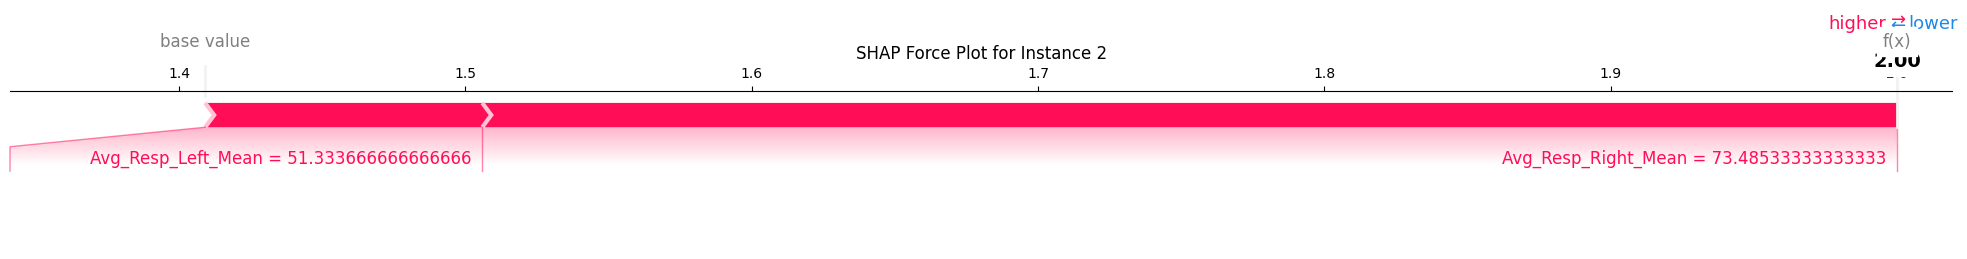

In [10]:
import matplotlib.pyplot as plt

# Get the feature names directly from the h2o_feature_frame for consistent labeling
feature_names = h2o_feature_frame.col_names

# Select the first two instances for plotting
instance_1_shap_values = shap_values_individual[0]
instance_1_features = df_clean[[col for col in feature_columns if col != y_col]].iloc[0]

instance_2_shap_values = shap_values_individual[1]
instance_2_features = df_clean[[col for col in feature_columns if col != y_col]].iloc[1]

print("Generating SHAP force plot for instance 1...")
shap.force_plot(expected_value, instance_1_shap_values, instance_1_features, matplotlib=True, show=False)
plt.title("SHAP Force Plot for Instance 1")
plt.tight_layout()
plt.show()

print("Generating SHAP force plot for instance 2...")
shap.force_plot(expected_value, instance_2_shap_values, instance_2_features, matplotlib=True, show=False)
plt.title("SHAP Force Plot for Instance 2")
plt.tight_layout()
plt.show()

# LightAutoML

In [13]:

!pip install -U lightautoml -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.5 MB/s eta 0:00:00


In [14]:
# Импорт библиотек для auto ml

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch

In [15]:
N_THREADS = 4 #number of vCPUs for LightAutoML model creation
N_FOLDS = 2 # number of folds in LightAutoML inner CV
#All models that are trained during the cross-validation loop
#on different folds are then saved for the inference phase.
#Inference on new data is made by averaging models from all train folds.

RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 100 # Time in seconds for automl run
TARGET_NAME = 'Avg_Resp_DTW_Cluster' # Target column name

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

autoML_df = df


In [16]:

train_data, test_data = train_test_split(
    autoML_df,
    test_size=TEST_SIZE,
    stratify=autoML_df[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (35, 9), test_data = (9, 9)


,patient_id,Avg_Resp_Left_Mean,Avg_Resp_Left_Std,Avg_Resp_Left_Hurst,Avg_Resp_Right_Mean,Avg_Resp_Right_Std,Avg_Resp_Right_Hurst,Avg_Resp_DTW_Cluster,Inh_Thresh_DTW_Cluster
15,patient_ 17,17.563361,5.387014,0.755658,58.702778,14.351963,1.483167,2,2
11,patient_ 13,73.081222,34.632446,1.891919,102.320833,33.402141,1.235124,2,2
32,patient_ 36,68.507836,19.408179,1.287754,82.181098,17.718535,1.375327,2,0
27,patient_ 30,70.664444,15.529956,1.516267,56.527579,15.725781,1.479974,2,1
25,patient_ 28,41.536417,13.203672,0.970299,198.331591,66.006541,1.012509,0,1


In [22]:
#The following task types are available:
#'binary' - for binary classification.
#'reg’ - for regression.
#‘multiclass’ - for multiclass classification.
#'multi:reg - for multiple regression.
#'multilabel' - for multi-label classification.

task = Task('multiclass')


roles = {
    'target': TARGET_NAME
    #'category': TARGET_NAME
    #'drop': ['name of column']
}

In [23]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [24]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 2)


[19:07:44] Stdout logging level is INFO2.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO2.


[19:07:44] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[19:07:44] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[19:07:44] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:07:44] - time: 100.00 seconds


INFO:lightautoml.automl.presets.base:- time: 100.00 seconds


[19:07:44] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:07:44] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:07:44] Train data shape: (35, 9)



INFO:lightautoml.reader.base:Train data shape: (35, 9)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:07:55] Layer 1 train process start. Time left 88.36 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 88.36 secs


[19:07:55] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0], 'embed_sizes': array([1], dtype=int32), 'data_size': 14}


[19:07:55] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.985606635948528
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.9842919337967267
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.9826543409037048
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.9697673728439374
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -0.9540120376743975
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -0.847930656784742
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -0.7493615071296635
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.44554250164359754
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 sco

[19:07:56] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.9629208535870464
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.9615297915762828
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.9597943626086526
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.9460597792707673
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -0.9294986620134136
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -0.817005560729733
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -0.7131180251055349
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.39633266308490456
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 sc

[19:07:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.05382947061833251


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.05382947061833251


[19:07:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:07:57] Time left 86.39 secs



INFO:lightautoml.automl.base:Time left 86.39 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816


[19:07:57] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[19:07:57] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[19:07:57] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816


[19:07:57] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.963346
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.963346
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.963346


[19:07:57] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


[19:07:57] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:07:57] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 16.65 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 16.65 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-ed5b78f2-74da-40b1-a985-56d2393e9688
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816
INFO:optuna.study.study:Trial 0 finished with value: -0.9858155600612718 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is 

[19:08:07] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[19:08:07] The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -0.9858 crossentropy


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -0.9858 crossentropy


[19:08:07] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.24810409748678125}


[19:08:07] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816


[19:08:07] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.963346
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.963346


[19:08:07] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.9749017075050724


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.9749017075050724


[19:08:07] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[19:08:07] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[19:08:07] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0772960	test: 1.0983647	best: 1.0983647 (0)	total: 46.2ms	remaining: 2m 18s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.1749088	test: 1.6263384	best: 1.0618592 (10)	total: 67.7ms	remaining: 1.94s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.061859228
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 10
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 11 iterations.


[19:08:07] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0798047	test: 1.0895169	best: 1.0895169 (0)	total: 252us	remaining: 758ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.3725230	test: 1.0653988	best: 0.9371854 (31)	total: 13.9ms	remaining: 399ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9371853616
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 31
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 32 iterations.


[19:08:07] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.001303354020897


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.001303354020897


[19:08:07] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[19:08:07] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 46.84 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 46.84 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-1f0f2220-e7fb-449e-9fc1-cb2c40df7141
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0915618	test: 1.0965455	best: 1.0965455 (0)	total: 237us	remaining: 711ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.6512793	test: 1.0858864	best: 1.0474943 (45)	total: 11.3ms	remaining: 324ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.047494273
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 45
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 46 iterations.
INFO:optuna.study.study:Trial 0 finished with value: -1.0474942854106297 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf

[19:08:16] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[19:08:16] The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 2.103655408016812, 'min_data_in_leaf': 10}
 achieve -1.0409 crossentropy


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 2.103655408016812, 'min_data_in_leaf': 10}
 achieve -1.0409 crossentropy


[19:08:16] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 2.103655408016812, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 10, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[19:08:16] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0888644	test: 1.0960796	best: 1.0960796 (0)	total: 165us	remaining: 496ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.5919019	test: 1.1143181	best: 1.0409150 (39)	total: 17.1ms	remaining: 490ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.040915037
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 39
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 40 iterations.


[19:08:16] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0925616	test: 1.0929687	best: 1.0929687 (0)	total: 173us	remaining: 522ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.8034095	test: 0.9168264	best: 0.9168264 (100)	total: 16.8ms	remaining: 483ms
INFO3:lightautoml.ml_algo.boost_cb:200:	learn: 0.6772999	test: 0.9212185	best: 0.9134717 (111)	total: 33.9ms	remaining: 472ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9134717047
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 111
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 112 iterations.


[19:08:16] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.9790139774023008


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.9790139774023008


[19:08:16] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[19:08:16] Time left 67.78 secs



INFO:lightautoml.automl.base:Time left 67.78 secs



[19:08:16] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[19:08:16] Layer 2 train process start. Time left 67.76 secs


INFO:lightautoml.automl.base:Layer 2 train process start. Time left 67.76 secs


[19:08:16] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0], 'embed_sizes': array([1], dtype=int32), 'data_size': 29}


[19:08:16] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.9891858664597566
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.9868860542518326
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.9799506140254982
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.9580995375729725
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -0.9320422258450909
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -0.7770792930199075
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -0.6597367311606042
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.3883426814226779
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 sc

[19:08:19] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.9627907798505381
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.9603951337215406
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.9574051441602272
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.9340759597528252
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -0.9069750774018299
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -0.7385382015339248
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -0.606169920075649
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.32451598867129916
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 sc

[19:08:20] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.14519177207975079


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.14519177207975079


[19:08:20] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:08:20] Time left 63.55 secs



INFO:lightautoml.automl.base:Time left 63.55 secs



[19:08:20] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[19:08:20] ===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816


[19:08:20] ===== Start working with fold 1 for Lvl_1_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.963346
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.963346
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.963346


[19:08:20] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


[19:08:20] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:08:20] Time left 63.41 secs



INFO:lightautoml.automl.base:Time left 63.41 secs



[19:08:20] Layer 2 training completed.



INFO:lightautoml.automl.base:Layer 2 training completed.



[19:08:20] Blending: optimization starts with equal weights. Score = -0.4468945


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = -0.4468945


[19:08:20] Blending: iteration 0: score = -0.1451918, weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.1451918, weights = [1. 0.]


[19:08:20] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[19:08:20] Blending: best score = -0.1451918, best weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: best score = -0.1451918, best weights = [1. 0.]


[19:08:20] Automl preset training completed in 36.66 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 36.66 seconds



[19:08:20] Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



INFO:lightautoml.automl.presets.base:Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



In [25]:

test_predictions = automl.predict(test_data).data
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
#plt.plot(test_predictions.data[:],'.')

Prediction for test_data:
[[3.5040699e-02 1.0712132e-02 9.5424712e-01]
 [5.3997670e-04 9.8796856e-01 1.1491456e-02]
 [1.7767298e-04 1.3792558e-03 9.9844307e-01]
 [3.3864684e-02 7.1578333e-03 9.5897746e-01]
 [7.0525333e-05 3.9527167e-05 9.9988997e-01]
 [8.6500766e-03 9.8154175e-01 9.8081557e-03]
 [4.8208451e-03 2.3102723e-02 9.7207642e-01]
 [3.2180885e-04 9.3827862e-03 9.9029541e-01]
 [5.7279188e-03 9.9316990e-01 1.1021626e-03]]
Shape = (9, 3)


In [27]:

RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [29]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)


[19:10:32] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[19:10:32] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[19:10:32] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:10:32] - time: 100.00 seconds


INFO:lightautoml.automl.presets.base:- time: 100.00 seconds


[19:10:32] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:10:32] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:10:32] Train data shape: (35, 9)



INFO:lightautoml.reader.base:Train data shape: (35, 9)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:10:32] Layer 1 train process start. Time left 99.84 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 99.84 secs


[19:10:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0], 'embed_sizes': array([1], dtype=int32), 'data_size': 14}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.985606635948528
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.9842919337967267
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.9826543409037048
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.9697673728439374
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -0.9540120376

[19:10:34] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.05382947061833251


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.05382947061833251


[19:10:34] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:10:34] Time left 98.03 secs



INFO:lightautoml.automl.base:Time left 98.03 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816


[19:10:34] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[19:10:34] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816
INFO2:lightautoml.ml_algo.

[19:10:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


[19:10:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:10:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 19.51 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 19.51 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-7551d44b-cd46-4ce4-a922-241c6bf30c3b
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816
INFO:optuna.study.study:Trial 0 finished with value: -0.9858155600612718 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is 

[19:10:44] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -0.9858 crossentropy


[19:10:44] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	va

[19:10:44] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.9749017075050724


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.9749017075050724


[19:10:44] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[19:10:44] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0772960	test: 1.0983647	best: 1.0983647 (0)	total: 266us	remaining: 800ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.1749088	test: 1.6263384	best: 1.0618592 (10)	total: 20.9ms	remaining: 599ms
INFO3:lightautoml.ml_al

[19:10:45] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.001303354020897


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.001303354020897


[19:10:45] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[19:10:45] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 55.40 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 55.40 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c9cdaed6-077a-407f-9411-99ccbb75e96c
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0915618	test: 1.0965455	best: 1.0965455 (0)	total: 208us	remaining: 626ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.6512793	test: 1.0858864	best: 1.0474943 (45)	total: 15.7ms	remaining: 450ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.047494273
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 45
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 46 iterations.
INFO:optuna.study.study:Trial 0 finished with value: -1.0474942854106297 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf

[19:10:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 2.103655408016812, 'min_data_in_leaf': 10}
 achieve -1.0409 crossentropy


[19:10:54] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 2.103655408016812, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 10, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0888644	test: 1.0960796	best: 1.0960796 (0)	total: 171us	remaining: 516ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.5919019	test: 1.1143181	best: 1.0409150 (39)	total: 14.1ms	remaining: 406

[19:10:54] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.9790139774023008


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.9790139774023008


[19:10:54] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[19:10:54] Time left 78.34 secs



INFO:lightautoml.automl.base:Time left 78.34 secs



[19:10:54] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[19:10:54] Layer 2 train process start. Time left 78.32 secs


INFO:lightautoml.automl.base:Layer 2 train process start. Time left 78.32 secs


[19:10:54] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0], 'embed_sizes': array([1], dtype=int32), 'data_size': 29}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.9891858664597566
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.9868860542518326
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.9799506140254982
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.9580995375729725
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -0.932042225

[19:10:57] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.14519177207975079


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.14519177207975079


[19:10:57] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:10:57] Time left 74.91 secs



INFO:lightautoml.automl.base:Time left 74.91 secs



[19:10:57] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.985816
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 0.985816
INFO2:lightautoml.ml_algo.

[19:10:57] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.9749017075050724


[19:10:57] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:10:57] Time left 74.81 secs



INFO:lightautoml.automl.base:Time left 74.81 secs



[19:10:57] Layer 2 training completed.



INFO:lightautoml.automl.base:Layer 2 training completed.



[19:10:57] Blending: optimization starts with equal weights. Score = -0.4468945


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = -0.4468945


[19:10:57] Blending: iteration 0: score = -0.1451918, weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.1451918, weights = [1. 0.]


[19:10:57] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[19:10:57] Blending: best score = -0.1451918, best weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: best score = -0.1451918, best weights = [1. 0.]


[19:10:57] Automl preset training completed in 25.26 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 25.26 seconds



[19:10:57] Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



INFO:lightautoml.automl.presets.base:Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



In [30]:
# Fast feature importances calculation
# we will use automl_rd.model instead automl_rd because
# we want to take the importances from the model, not from the report.

fast_fi = automl_rd.model.get_feature_scores('fast')
#fast_fi = automl.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (13, 3), grid = True)

<Axes: xlabel='Feature'>

In [31]:

explainer = SSWARM(automl_rd.model)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

100%|██████████| 1500/1500 [00:47<00:00, 31.67it/s]


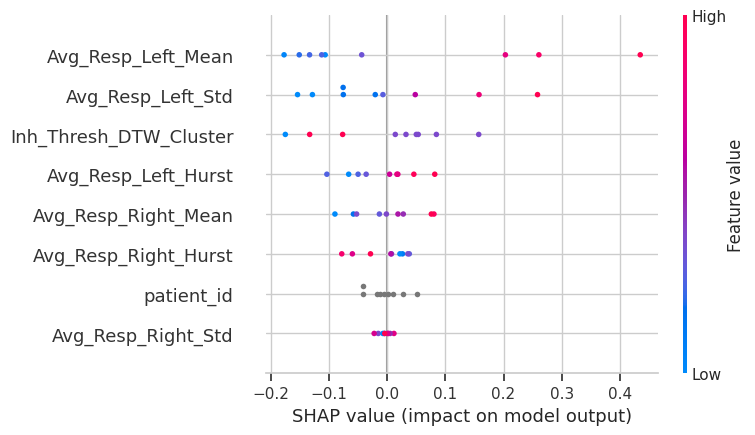

In [36]:
shap.summary_plot(shap_values[1], test_data[list(explainer.used_feats)])

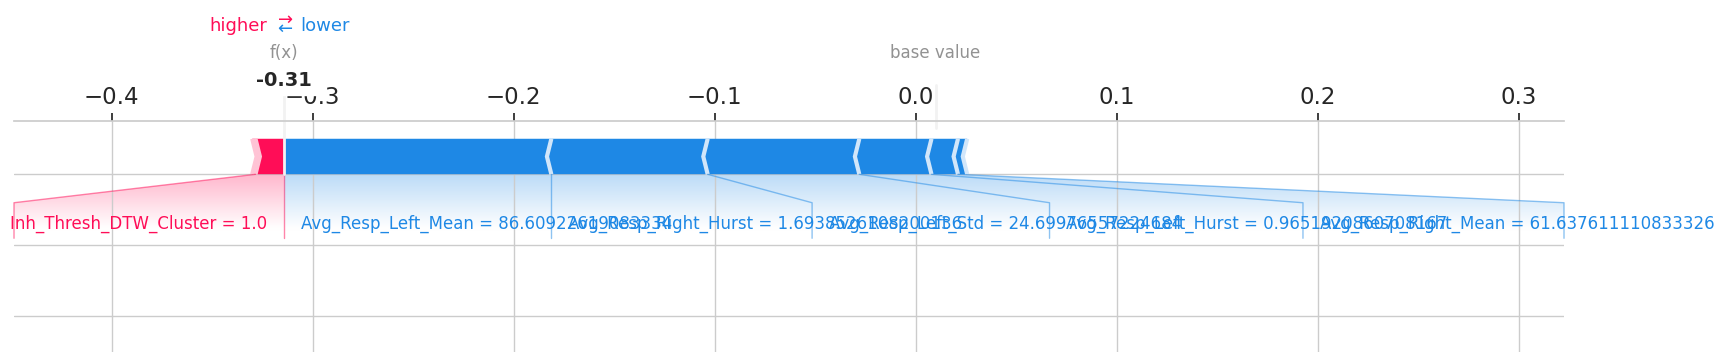

In [37]:

# individual force plot
shap.force_plot(explainer.expected_value[0], shap_values[1][0],
                test_data[explainer.used_feats].iloc[0], matplotlib=True)

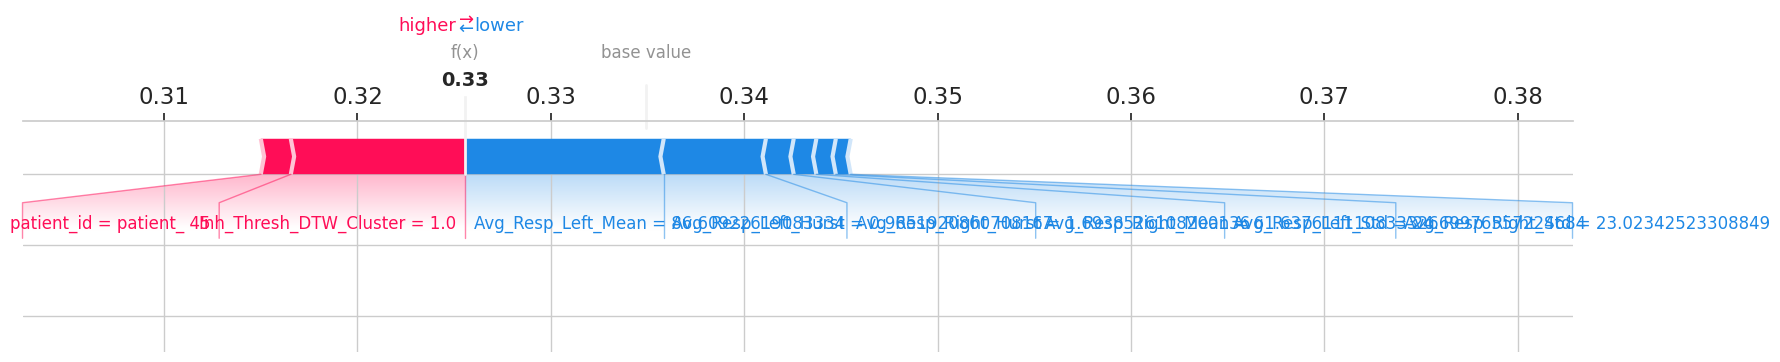

In [39]:
# individual force plot
shap.force_plot(explainer.expected_value[1], shap_values[0][1],
                test_data[explainer.used_feats].iloc[0], matplotlib=True)

In [34]:

X_test = test_data
X_test.reset_index(drop=['index'], inplace=True)
X_test = X_test.drop(columns=TARGET_NAME)
X_test.reset_index(drop=['index'], inplace=True)

In [35]:
shap.initjs()
shap.force_plot(explainer.expected_value[0],
                shap_values[0], X_test)